In [1]:
# 导入必要的库
import os
os.chdir('../')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# 训练数据个数
data_size = 10000
# 测试数据个数
testing_examples = 1000
# sin函数的采样间隔
sample_gap = 0.01
# 每个训练样本的长度
time_step_size = 5

def generate_data(seq):
    X = []
    y = []

    for i in range(len(seq) - time_step_size):
        X.append(seq[i : i+time_step_size])
        y.append(seq[i+time_step_size])

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

test_start = data_size*sample_gap
test_end = test_start + data_size*sample_gap

train_x, train_y = generate_data(np.sin(np.linspace(0, test_start, data_size)))
test_x, test_y = generate_data(np.sin(np.linspace(test_start, test_end, testing_examples)))

print('train_x : {}, train_y : {}'.format(train_x.shape, train_y.shape),
      'test_x : {}, test_y : {}'.format(test_x.shape, test_y.shape))

train_x : (9995, 5), train_y : (9995,) test_x : (995, 5), test_y : (995,)


In [10]:
###############################################################################
#                            Model   Parameter                                #
#                               lr : 学习率                                   #
#                       input_size : 输入维数                                 #
#                      output_size : 输出维数                                 #
#                      hidden_size : 隐藏层维数                               #
#                       batch_size : 批大小                                   #
###############################################################################
lr = 1e-3
input_size = 1
output_size = 1
hidden_size = 64
batch_size = 64

# 重置 tensorflow 计算图
tf.reset_default_graph()

In [11]:
###############################################################################
#                               RNN   architecture                            #
###############################################################################
x = tf.placeholder(tf.float32, [None, time_step_size, input_size])
y = tf.placeholder(tf.float32, [None, output_size])
# RNN cell
cell = tf.contrib.rnn.GRUCell(hidden_size)
# defining initial state
initial_state = cell.zero_state(batch_size, dtype=tf.float32)
# 'state' is a tensor of shape [batch_size, cell_state_size]
outputs, state = tf.nn.dynamic_rnn(cell,
                                   x,
                                   initial_state=initial_state,
                                   dtype=tf.float32)
# output layer
W = tf.get_variable(name = 'output_layer_W',
                    shape = (hidden_size, output_size),
                    initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable(name = 'output_layer_b',
                    shape = (1, output_size),
                    initializer=tf.constant_initializer(0))
output = tf.matmul(outputs[:,-1], W) + b

loss = tf.reduce_mean(tf.abs(output - y))
optimizer = tf.train.AdamOptimizer(lr).minimize(loss)

epoch 12 loss : 0.02230345830321312
epoch 24 loss : 0.019675523042678833
epoch 36 loss : 0.01689651608467102
epoch 48 loss : 0.012267905287444592
epoch 60 loss : 0.010291705839335918
epoch 72 loss : 0.008620242588222027
epoch 84 loss : 0.007919215597212315
epoch 96 loss : 0.005264157894998789
epoch 108 loss : 0.005410676822066307
epoch 120 loss : 0.00481170741841197


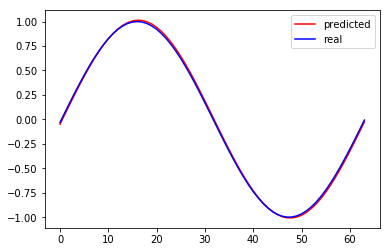

In [12]:
###############################################################################
#                               Model train                                   #
###############################################################################
iteration = data_size // batch_size

session = tf.Session()

with session.as_default() as sess:
    sess.run(tf.global_variables_initializer())

    epoch = 120
    for i in range(1, epoch+1):

        losses = []

        for j in range(iteration):
            index = np.random.choice(iteration-1)
            start = index * batch_size
            end = (index+1) * batch_size
            feed_dict = {x:train_x[start:end,:,None], y:train_y[start:end,None]}

            cost, _ = sess.run([loss, optimizer], feed_dict=feed_dict)
            losses.append(cost)
        if i % (epoch / 10) == 0:
            print('epoch {} loss : {}'.format(i, np.mean(losses)))

    py, = sess.run([output], feed_dict={x:test_x[:batch_size,:,None]})
    plt.plot(py, 'r', label='predicted')
    plt.plot(test_y[:batch_size], 'b', label='real')
    plt.legend(loc=1)